# Importing Dependencies

In [65]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16



In [66]:
# Test basic functionality
try:
    print("NumPy version:", np.__version__)
    arr = np.array([1, 2, 3])
    print("Random choice:", random.choice(arr))
    
    image = Image.new("RGB", (100, 100), color="red")
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(1.5)

    arr_shuffled = shuffle(arr)
    print("Shuffled array:", arr_shuffled)

    model = Sequential([
        Input(shape=(64, 64, 3)),
        Flatten(),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    print("Model compiled successfully")

    vgg = VGG16(include_top=False, input_shape=(64, 64, 3))
    print("VGG16 loaded successfully")

    print("All imports and tests passed successfully ✅")
except Exception as e:
    print("Error:", e)

NumPy version: 1.26.4
Random choice: 1
Shuffled array: [1 3 2]
Model compiled successfully
VGG16 loaded successfully
All imports and tests passed successfully ✅


# Load Dataset

In [67]:
# Directories for training and testing
train_dir = 'data/train/'
test_dir = 'data/test/'

# Load and Shuffle th train data

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and Shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)




# Data Visualization

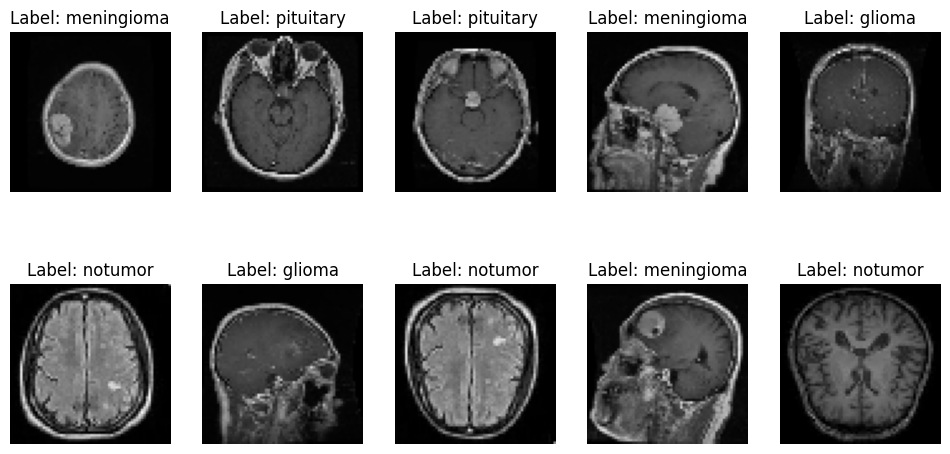

In [68]:
import random
import matplotlib.pyplot as plt

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display the images in 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# Loop through the random indices and display the images
for i, idex in enumerate(random_indices):
    # Load the image
    img = load_img(train_paths[idex], target_size=(64, 64))
    
    # Convert to array and normalize
    img_array = np.array(img) / 255.0
    
    # Display the image
    axes[i].imshow(img_array)
    axes[i].set_title(f"Label: {train_labels[idex]}")
    axes[i].axis('off')


# Image Preprocessing

In [69]:
IMAGE_SIZE = 128

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


# Encode label function
def encode_label(labels):
    unique_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Use the exact order of your folders
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# Model

I am using VGG16 for transfer learning. The model is built on top of VGG16, a pre-trained convolutional neural network (CNN) designed for image classification.

First, I load the VGG16 model with the parameters input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, and weights='imagenet'. The input shape is set to match the dimensions of the images in the dataset, which are 128x128 pixels. By setting include_top=False, I exclude the final fully-connected layers of VGG16 that perform classification. The weights='imagenet' parameter indicates that the model is pre-trained on the ImageNet dataset, which contains approximately 1.4 million images.

Next, I use a for loop (for layer in base_model.layers:) to set all layers of the base model (VGG16) to non-trainable. This ensures that the weights of these layers remain unchanged during training.

Then, I selectively unfreeze the last three layers of the VGG16 model by setting base_model.layers[-2].trainable = True, base_model.layers[-3].trainable = True, and base_model.layers[-4].trainable = True.

After that, I create a Sequential model and add the VGG16 base model to it using model.add(base_model).

Next, I add a Flatten layer using model.add(Flatten()), which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor so it can be passed to the subsequent dense layers.

Then, I include a Dropout layer with a dropout rate of 0.3 using model.add(Dropout(0.3)). This helps prevent overfitting by randomly setting a fraction of the input units to 0 during training.

After that, I add a Dense layer with 128 neurons and a ReLU activation function using model.add(Dense(128, activation='relu')).

Next, I add another Dropout layer with a rate of 0.2 using model.add(Dropout(0.2)).

Finally, I add the output Dense layer with the number of neurons equal to the number of unique labels and a softmax activation function using model.add(Dense(len(unique_labels), activation='softmax')). The softmax activation function provides a probability distribution over the possible output classes.

In [70]:
len(os.listdir(train_dir))

4

In [71]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 0.7504 - sparse_categorical_accuracy: 0.7265
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.8795
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9178
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9312
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.9524


# Train and Val Plots

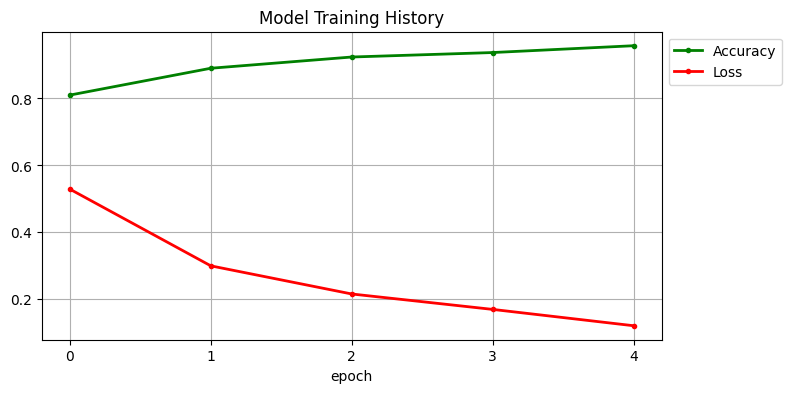

In [72]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       300
           1       0.95      0.77      0.85       306
           2       0.98      0.97      0.98       405
           3       0.91      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.93      0.92      1311



# Model Confusion Plot

Confusion Matrix:
[[290   9   0   1]
 [ 41 235   6  24]
 [ 10   0 392   3]
 [  1   3   0 296]]


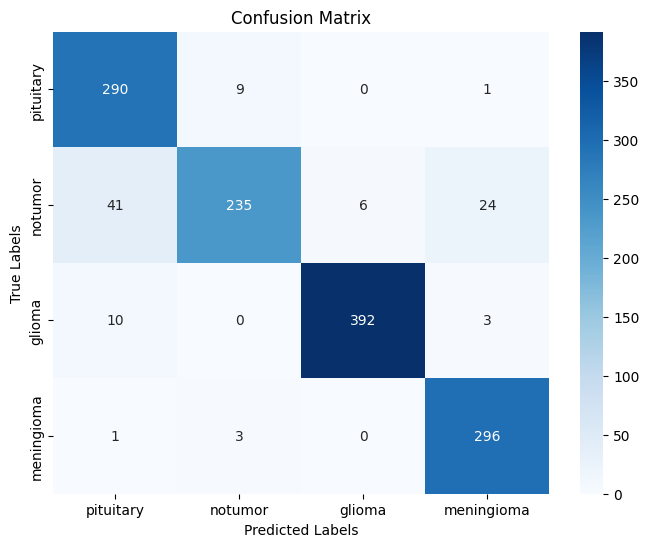

In [74]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot

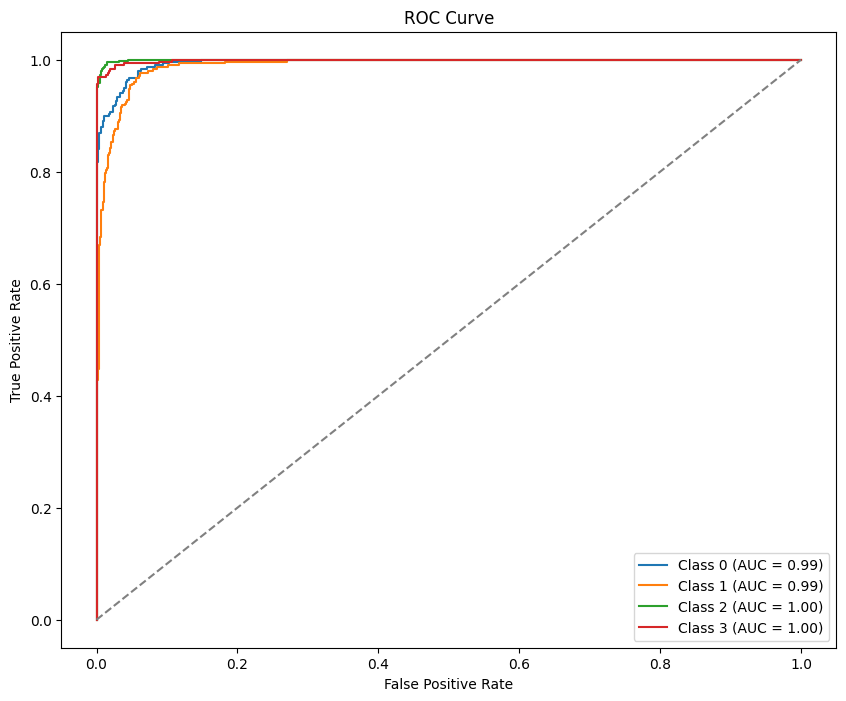

In [75]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save and Load Model

In [ ]:

import json
class_mapping = {i: label for i, label in enumerate(class_labels)}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

# Save the entire model
model.save('model/model.h5')

In [77]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

with open('class_mapping.json', 'r') as f:
    class_mapping = json.load(f)
class_labels = [class_mapping[str(i)] for i in range(len(class_mapping))]

# MRI Tumor Detection System

In [78]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


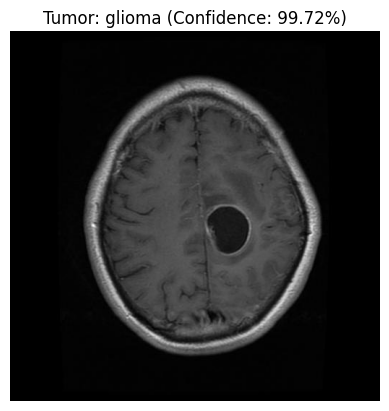

In [83]:
# Example usage
image_path = 'data/test/glioma/Te-gl_0291.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


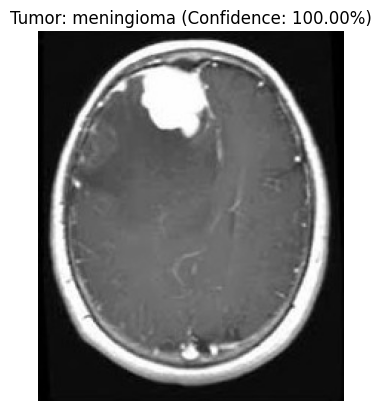

In [85]:
# Example usage
image_path = 'data/test/meningioma/Te-meTr_0008.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


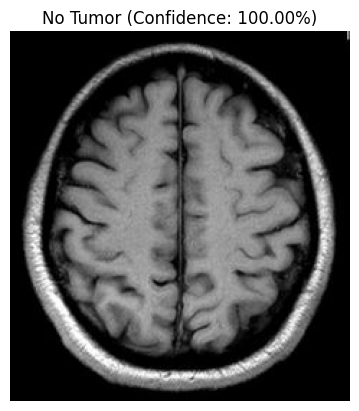

In [86]:
# Example usage
image_path = 'data/test/notumor/Te-no_0030.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


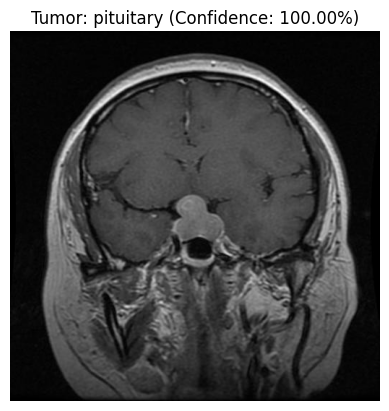

In [88]:
# Example usage
image_path = 'data/test/pituitary/Te-pi_0107.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)